In [1]:
from pyspark.sql import SparkSession, Row, SQLContext
from pyspark.sql.functions import udf, col, date_format
import pyspark.sql.types as T
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel, IDF, RegexTokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA, LocalLDAModel
from pyspark.ml import Pipeline
from nltk.corpus import stopwords
#from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import re
import nltk

%matplotlib inline 
sns.set_style("whitegrid")

In [2]:
spark = SparkSession.builder.appName('NLP').getOrCreate()

## Preprocess

In [3]:
df = spark.read.csv("data/merged_df_final.csv", header=True)

In [4]:
df = df[['province_state', 'date', 'confirmed_state', 'deaths_state', 'governor_tweet']]
df = df.drop_duplicates(subset=['governor_tweet', 'province_state'])
df = df.dropna()

In [5]:
df.show()

+--------------+----------+---------------+------------+--------------------------+
|province_state|      date|confirmed_state|deaths_state|            governor_tweet|
+--------------+----------+---------------+------------+--------------------------+
|       Florida|2020/08/31|       623471.0|     11187.0|      (8/8): ED visits ...|
|      Illinois|2020/04/26|        43903.0|      1933.0|      4/26 COVID-19 Dai...|
|      Delaware|2020/06/03|         9712.0|       375.0|      As businesses reo...|
|  North Dakota|2021/01/15|        95599.0|      1395.0|      At 3:00 p.m. we w...|
|      Missouri|2020/06/01|        13724.0|       776.0|      Before COVID-19, ...|
|        Oregon|2020/04/30|         2510.0|       103.0|COVID-19에 관한 이 자료...|
|      Illinois|2020/06/25|       139434.0|      6810.0|      Como resultado, h...|
|     Louisiana|2020/08/26|       144960.0|      4851.0|      Despite progress ...|
|        Oregon|2020/11/14|        56018.0|       759.0|      During the Two-We...

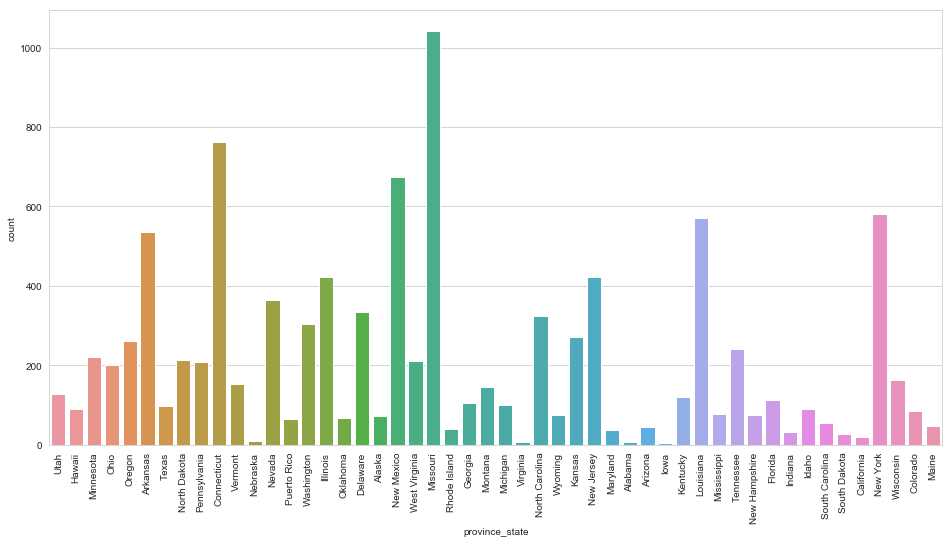

In [44]:
tweet_p_state = (df.groupBy('province_state')
                 .count())
tweet_p_state_df = tweet_p_state.toPandas()

plt.rcParams["figure.figsize"] = (16,8)
sns.barplot(x = 'province_state', y = 'count', data=tweet_p_state_df)
plt.xticks(rotation = 90, size = 10)
plt.show();
#tweet_p_state_df

In [7]:
texts=df.rdd.map(lambda x: x['governor_tweet'])
tweets=texts.zipWithIndex()
data = spark.createDataFrame(tweets, ["tweets",'index'])

removePunct = udf(
    lambda s: re.sub(r'[^a-zA-Z0-9]|[0-9]', r' ', s).strip().lower(), T.StringType())

# normalize the post content (remove html tags, punctuation and lower case..)
data_norm = data.withColumn("text", removePunct(data.tweets))

In [11]:
tokenizer = RegexTokenizer(inputCol="text", outputCol="words",
                           gaps=True, pattern=r'\s+', minTokenLength=2)
df_tokens = tokenizer.transform(data_norm)

nltk.download('stopwords')#must be downloaded to run
stop_words = stopwords.words("english") + ["which", "amp", "who", "whose", "xa", "de", "http"]
removeStop=udf(lambda word: [x for x in word if x not in stop_words])
df_tokens=df_tokens.withColumn('noStopWords',removeStop(df_tokens['words']))

label_udf = udf(lambda x: x, T.ArrayType(T.StringType())) 
df_tokens=df_tokens.withColumn('final_words',label_udf(df_tokens.noStopWords))

[nltk_data] Downloading package stopwords to /Users/miao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df_tokens.printSchema()

root
 |-- tweets: string (nullable = true)
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- noStopWords: string (nullable = true)
 |-- final_words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [12]:
df_tokens[['tweets', 'index', 'final_words']].show()

+--------------------------+-----+--------------------+
|                    tweets|index|         final_words|
+--------------------------+-----+--------------------+
|      (8/8): ED visits ...|    0|[ed, visits, covi...|
|      4/26 COVID-19 Dai...|    1|[covid, daily, br...|
|      As businesses reo...|    2|[businesses, reop...|
|      At 3:00 p.m. we w...|    3|[host, covid, pre...|
|      Before COVID-19, ...|    4|[covid, one, prio...|
|COVID-19에 관한 이 자료...|    5|[covid, https, co...|
|      Como resultado, h...|    6|[como, resultado,...|
|      Despite progress ...|    7|[despite, progres...|
|      During the Two-We...|    8|[two, week, freez...|
|      Georgia continues...|    9|[georgia, continu...|
|      Great job Galvest...|   10|[great, job, galv...|
|      I got my first CO...|   11|[got, first, covi...|
|      I will be testify...|   12|[testifying, subc...|
|      Ill be joined by ...|   13|[ill, joined, cvs...|
|      It’s incumbent up...|   14|[incumbent, upon,...

## TF-IDF

In [13]:
%%time
# TF
#VocabSize of 20000 words and words with frequencies above 10
cv = CountVectorizer(inputCol="final_words", outputCol="raw_features",vocabSize=20000, minDF=10.0)
cvmodel = cv.fit(df_tokens)

result_cv = cvmodel.transform(df_tokens)

CPU times: user 34.3 ms, sys: 13.7 ms, total: 47.9 ms
Wall time: 14.5 s


In [14]:
%%time
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)

CPU times: user 25.8 ms, sys: 11.1 ms, total: 36.8 ms
Wall time: 7.2 s


In [15]:
%%time
#split 80% train set and 20% test set
df_training, df_testing = result_tfidf.randomSplit([0.8, 0.2], 1)
print('Training and testing documents: ', df_training.count(), df_testing.count())

num_topics=10
max_iterations=50
lda = LDA(k=num_topics, maxIter=max_iterations)
ldaModel = lda.fit(result_tfidf )

Training and testing documents:  8214 2098
CPU times: user 945 ms, sys: 446 ms, total: 1.39 s
Wall time: 1min 18s


## Result

In [63]:
topics = ldaModel.describeTopics(maxTermsPerTopic=5)
vocabArray = cvmodel.vocabulary
numTopics=10

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

toptopics = topics.select((topics.topic + 1).alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words'),
                          FormatNumbers(topics.termWeights).alias('weights'))
toptopics.show(truncate=False, n=numTopics)
print('Topics:', numTopics, 'Vocabulary:', len(vocabArray))

/anaconda3/lib/python3.7/site-packages/pyspark/sql/context.py:126: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  DeprecationWarning)


+-----+---------------------------------------------+----------------------------------------+
|topic|words                                        |weights                                 |
+-----+---------------------------------------------+----------------------------------------+
|1    |[testing, get, test, find, sites]            |[0.0242, 0.0126, 0.0108, 0.0096, 0.0095]|
|2    |[spread, mask, stay, keep, wear]             |[0.0145, 0.0116, 0.0112, 0.0101, 0.0097]|
|3    |[statewide, deaths, cases, additional, new]  |[0.0294, 0.0276, 0.0273, 0.0248, 0.0225]|
|4    |[watch, live, briefing, pm, director]        |[0.0260, 0.0206, 0.0203, 0.0190, 0.0148]|
|5    |[patients, care, force, hospitals, task]     |[0.0189, 0.0153, 0.0112, 0.0112, 0.0110]|
|6    |[businesses, help, small, support, business] |[0.0135, 0.0108, 0.0097, 0.0084, 0.0079]|
|7    |[vaccine, doses, care, state, first]         |[0.0124, 0.0087, 0.0083, 0.0072, 0.0068]|
|8    |[information, call, response, provides, liv

In [64]:
#Add more words to plot the wordcloud
topics1 = ldaModel.describeTopics(maxTermsPerTopic=15)
topics_rdd = topics1.rdd

topic_words = topics_rdd \
        .map(lambda row: row['termIndices']) \
        .map(lambda idx_list: [vocabArray[idx] for idx in idx_list]) \
        .collect()

topic_weights = topics_rdd \
        .map(lambda row: row['termWeights']) \
        .collect()

    # Store topic words and weights as a list of dicts
topics1 = [dict(zip(words, weights))
              for words, weights in zip(topic_words, topic_weights)]

/anaconda3/lib/python3.7/site-packages/pyspark/sql/context.py:126: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  DeprecationWarning)


In [65]:
topics1

[{'testing': 0.02417118215274287,
  'get': 0.012621698262425787,
  'test': 0.010780274626219008,
  'find': 0.009632389323359905,
  'sites': 0.009534749049058778,
  'symptoms': 0.0076067430913985025,
  'tested': 0.007464150204360707,
  'site': 0.007459141451444113,
  'free': 0.0071402312323749564,
  'vaccine': 0.0068864709430198415,
  'county': 0.006173422144560222,
  'near': 0.006137871957352049,
  'flu': 0.005931682202449949,
  'vaccines': 0.005647526007447214,
  'level': 0.0053252858840484325},
 {'spread': 0.014520078661735143,
  'mask': 0.011610813459774326,
  'stay': 0.011196011875920241,
  'keep': 0.010055434339356024,
  'wear': 0.00971017097576812,
  'home': 0.009560609003150786,
  'protect': 0.008689420935167351,
  'social': 0.008572456326301907,
  'slow': 0.008361900739554362,
  'take': 0.00797555357649817,
  'virus': 0.007606081342915889,
  'safe': 0.0076041257618843046,
  'face': 0.007174767655085539,
  'us': 0.00702051732451124,
  'lagov': 0.006819310346846479},
 {'statewide

  0%|          | 0/10 [00:00<?, ?it/s]

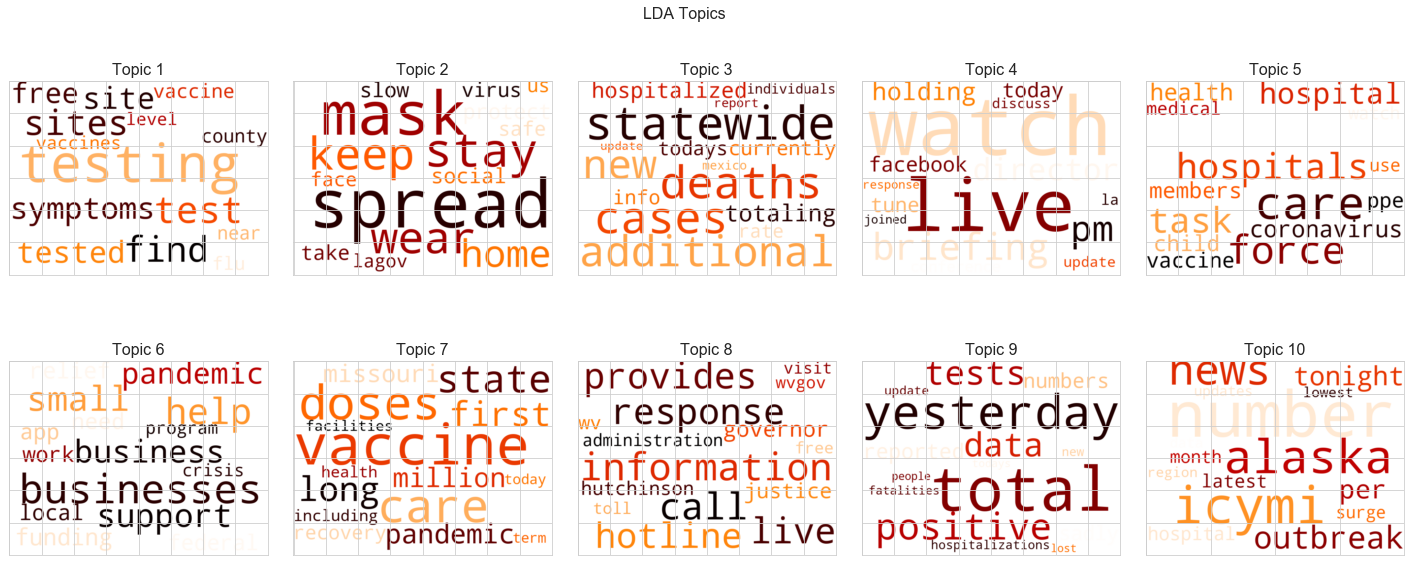

In [77]:
from math import ceil
from tqdm.notebook import tqdm

def plot_wordclouds(topics, colormap="gist_heat"):
    cloud = WordCloud(
        background_color='white',
        width=800,
        height=600,
        colormap=colormap,
        prefer_horizontal=1.0,
    )

    num_topics = len(topics)
    fig = plt.figure(figsize=(25, 15))

    for idx, word_weights in tqdm(enumerate(topics), total=num_topics):
        ax = fig.add_subplot((num_topics / 5) + 1, 5, idx + 1)
        wordcloud = cloud.generate_from_frequencies(word_weights)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title('Topic {}'.format(idx + 1), size = 16)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.tick_params(labelsize=16)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    st = fig.suptitle("LDA Topics", y=0.92, size = 16)
    fig.savefig("pyspark-topics.png", bbox_extra_artists=[st], bbox_inches='tight')

plot_wordclouds(topics1)
plt.savefig('LDA_wc')

## Evaluate

In [16]:
lpt, lp = ldaModel.logPerplexity(df_testing), ldaModel.logPerplexity(df_training)
print("Perplexity on testing and training data: " + str(lp) + ',' + str(lpt))

Perplexity on testing and training data: 6.69577013712447,6.941993599041921


In [20]:
llt, ll = ldaModel.logLikelihood(df_testing), ldaModel.logLikelihood(df_training)
print("Likelihood on testing and training data: " + str(llt) + ',' + str(ll))

Likelihood on testing and training data: -986748.4898593953,-3699021.042064962


In [24]:
lda.save('agg_tweet.model')